---
title: py4DSTEM Parallax
authors: [Georgios Varnavides]
date: 2024/07/18
---

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import py4DSTEM

import ipywidgets
from IPython.display import display

### Load Data

In [2]:
file_path = 'data/'
file_data_01 = file_path + 'parallax_apoferritin_simulation_100eA2_01.h5'
file_data_02 = file_path + 'parallax_apoferritin_simulation_100eA2_02.h5'

dataset_01 = py4DSTEM.read(file_data_01)
dataset_02 = py4DSTEM.read(file_data_02)
dataset = py4DSTEM.DataCube(np.hstack((dataset_01.data,dataset_02.data)),calibration=dataset_01.calibration)
dataset

DataCube( A 4-dimensional array of shape (24, 48, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

### Basic Visualizations

In [3]:
mean_diffraction_pattern = dataset.get_dp_mean().data
mean_diffraction_pattern /= mean_diffraction_pattern.max()
bright_field_mask = mean_diffraction_pattern > 0.5
bright_field_mask_indices_vertical, bright_field_mask_indices_horizontal = np.where(bright_field_mask)

reciprocal_sampling = dataset.calibration.get_Q_pixel_size()
reciprocal_units = dataset.calibration.get_Q_pixel_units()
reciprocal_kwargs = {"pixelsize":reciprocal_sampling,"pixelunits":reciprocal_units,"scalebar":{"length":5},"ticks":False}

virtual_bright_field_images = dataset[:,:,bright_field_mask].transpose(2,0,1)
axial_r = 5
axial_bf_image = dataset[:,:,64-axial_r:64+axial_r,64-axial_r:64+axial_r].mean((-2,-1))

gridscan_sampling = dataset.calibration.get_R_pixel_size()
real_kwargs = {"pixelsize":gridscan_sampling/10,"pixelunits":"nm","scalebar":{"color":"black","length":10},"ticks":False}

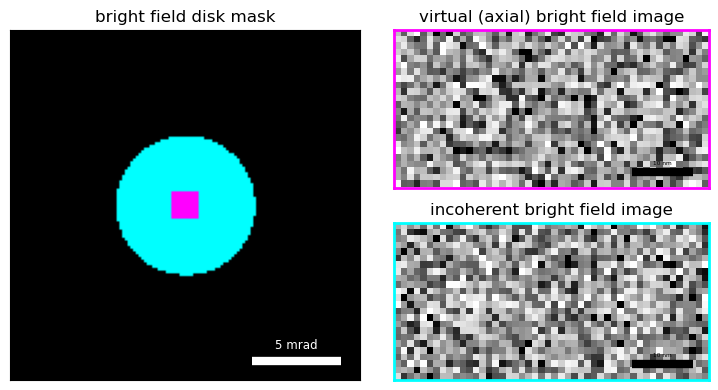

In [4]:
#| label: app:py4dstem_parallax_vbfs

fig = plt.figure(figsize=(7.5,4))

gs = GridSpec(2, 2, wspace=0.05)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

bright_field_mask_axial = bright_field_mask.copy().astype("int")
bright_field_mask_axial[64-axial_r:64+axial_r,64-axial_r:64+axial_r]=2,

bright_field_mask_rgb = np.zeros(bright_field_mask.shape+(3,))
bright_field_mask_rgb[bright_field_mask,1:] =1 
bright_field_mask_rgb[64-axial_r:64+axial_r,64-axial_r:64+axial_r,0]=1
bright_field_mask_rgb[64-axial_r:64+axial_r,64-axial_r:64+axial_r,1]=0
bright_field_mask_rgb[64-axial_r:64+axial_r,64-axial_r:64+axial_r,2]=1

py4DSTEM.show(
    bright_field_mask_rgb,
    figax=(fig,ax1),
    **reciprocal_kwargs,
    title="bright field disk mask",
)

py4DSTEM.show(
    axial_bf_image,
    figax=(fig,ax2),
    **real_kwargs,
    cmap='Greys',
    title="virtual (axial) bright field image",
    bordercolor="magenta",
    borderwidth=2,
)

py4DSTEM.show(
    virtual_bright_field_images.sum(0),
    figax=(fig,ax3),
    **real_kwargs,
    cmap='Greys',
    title="incoherent bright field image",
    bordercolor="cyan",
    borderwidth=2,
)

gs.tight_layout(fig)

### Iterative Alignment Bins

In [5]:
def return_bf_bins(bf_mask, bin_value, shift=0):
    """ """
    _xy_inds = np.argwhere(bf_mask)
    _xy_center = (_xy_inds - np.mean(_xy_inds, axis=0)).astype("float")
    _xy_inds_binned = np.round(_xy_center / bin_value + shift).astype("int")
    _xy_vals_binned = np.unique(_xy_inds_binned, axis=0)
    _inds_order = np.argsort(np.sum(_xy_vals_binned**2, axis=1))
    
    masks = np.zeros((_inds_order.shape[0],)+bf_mask.shape)
    for ind, bin_ind in enumerate(_inds_order):
        sub = np.logical_and(
            _xy_inds_binned[:, 0] == _xy_vals_binned[bin_ind, 0],
            _xy_inds_binned[:, 1] == _xy_vals_binned[bin_ind, 1],
        )
        indexing_i, indexing_j = _xy_inds[sub].T
        masks[ind,indexing_i,indexing_j]=1
    return masks

def return_bf_bins_rgb(bf_mask, bin_value, shift=0):
    """ """
    bins=return_bf_bins(bf_mask, bin_value, shift=shift)
    n = bins.shape[0]
    hue_angles = np.linspace(0.0, 2.0 * np.pi, n, endpoint=False)
    complex_arr = np.tensordot(np.exp(1j*hue_angles),bins,axes=1)
    return py4DSTEM.visualize.Complex2RGB(complex_arr)

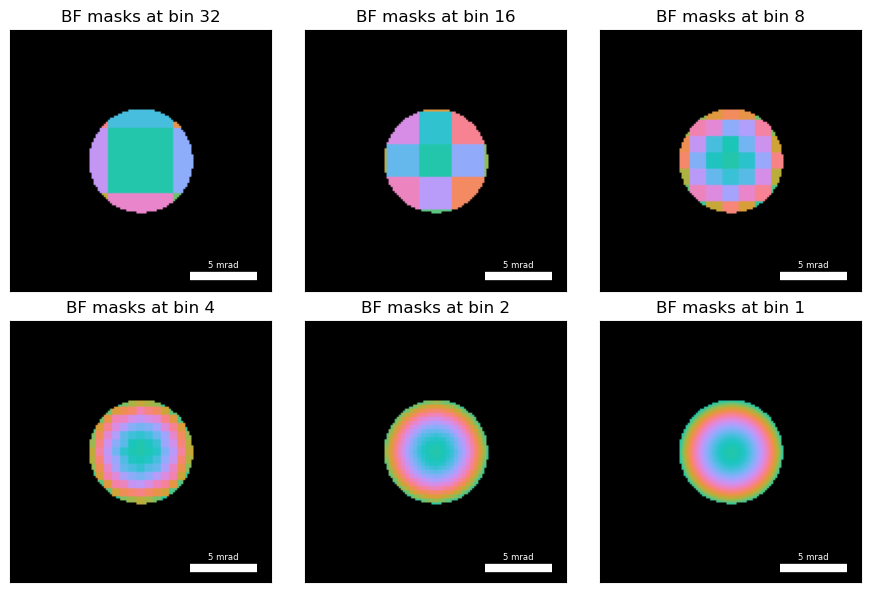

In [6]:
#| label: app:py4dstem_parallax_masks

bins_32 = return_bf_bins_rgb(bright_field_mask,32)
bins_16 = return_bf_bins_rgb(bright_field_mask,16)
bins_8 = return_bf_bins_rgb(bright_field_mask,8)
bins_4 = return_bf_bins_rgb(bright_field_mask,4)
bins_2 = return_bf_bins_rgb(bright_field_mask,2)
bins_1 = return_bf_bins_rgb(bright_field_mask,1)

py4DSTEM.show(
    [
        [bins_32, bins_16, bins_8],
        [bins_4, bins_2, bins_1]
    ],
    axsize=(3,3),
    **reciprocal_kwargs,
    title=[f"BF masks at bin {it}" for it in [32,16,8,4,2,1]]
)

### py4DSTEM Reconstruct

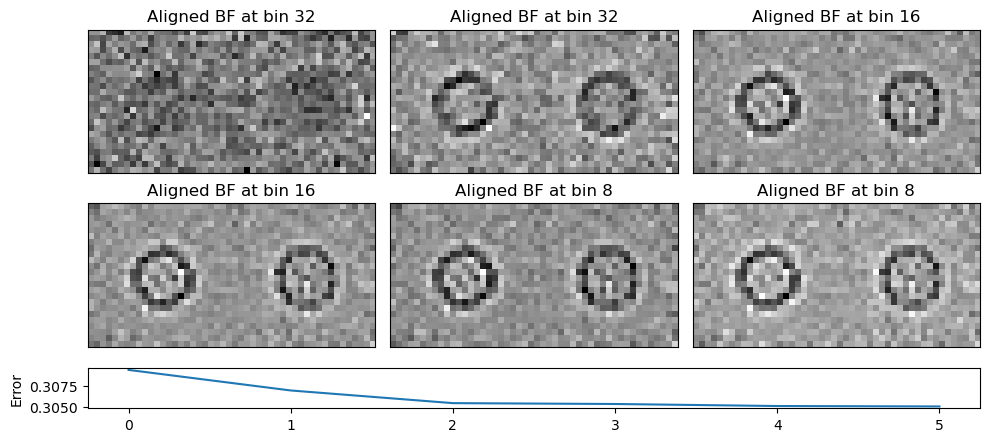

In [7]:
#| label: app:py4dstem_parallax_reconstruct

parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = 300e3,
    object_padding_px=(8,8),
).preprocess(
    edge_blend=4,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,16,16,8,8],
    progress_bar=False,
    figsize=(10,4.5),
    cmap='gray',
)

### Cross Corellation Shifts

In [8]:
#| label: app:py4dstem_parallax_shifts

style = {'description_width': 'initial'}

ipywidgets.interact(
    parallax.show_shifts,
    scale_arrows=ipywidgets.fixed(1),
    plot_rotated_shifts=ipywidgets.fixed(False),
    plot_arrow_freq=ipywidgets.IntSlider(min=1, max=16, step=1, value=4,style=style,description="plot arrow frequency"),
);

interactive(children=(IntSlider(value=4, description='plot arrow frequency', max=16, min=1, style=SliderStyle(…

In [9]:
def calculate_aberration_gradient_basis(
    sampling,
    gpts,
    wavelength,
    rotation_angle=0,
):
    """ """
    sx, sy = sampling
    nx, ny = gpts
    qx = np.fft.fftfreq(nx,sx)
    qy = np.fft.fftfreq(ny,sy)
    qx, qy = np.meshgrid(qx, qy, indexing="ij")

    # passive rotation
    qx, qy = qx * np.cos(-rotation_angle) + qy * np.sin(
        -rotation_angle
    ), -qx * np.sin(-rotation_angle) + qy * np.cos(-rotation_angle)

    # coordinate system
    qr2 = qx**2 + qy**2
    u = qx * wavelength
    v = qy * wavelength
    alpha = np.sqrt(qr2) * wavelength
    theta = np.arctan2(qy, qx)

    _aberrations_mn = [[1,0,0],[1,2,0],[1,2,1],[2,1,0],[2,1,1],[3,0,0]]
    _aberrations_n = len(_aberrations_mn)
    _aberrations_basis = np.zeros((alpha.size, _aberrations_n))
    _aberrations_basis_du = np.zeros((alpha.size, _aberrations_n))
    _aberrations_basis_dv = np.zeros((alpha.size, _aberrations_n))

    for a0 in range(_aberrations_n):
        m, n, a = _aberrations_mn[a0]

        if n == 0:
            # Radially symmetric basis
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (u * alpha ** (m - 1)).ravel()
            _aberrations_basis_dv[:, a0] = (v * alpha ** (m - 1)).ravel()

        elif a == 0:
            # cos coef
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) * np.cos(n * theta) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * u * np.cos(n * theta) + n * v * np.sin(n * theta))
                / (m + 1)
            ).ravel()
            _aberrations_basis_dv[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * v * np.cos(n * theta) - n * u * np.sin(n * theta))
                / (m + 1)
            ).ravel()

        else:
            # sin coef
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) * np.sin(n * theta) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * u * np.sin(n * theta) - n * v * np.cos(n * theta))
                / (m + 1)
            ).ravel()
            _aberrations_basis_dv[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * v * np.sin(n * theta) + n * u * np.cos(n * theta))
                / (m + 1)
            ).ravel()

    # global scaling
    _aberrations_basis *= 2 * np.pi / wavelength
    
    return _aberrations_basis, _aberrations_basis_du, _aberrations_basis_dv

In [17]:
def plot_estimated_shifts(
    sampling=parallax._scan_sampling,
    gpts=parallax._region_of_interest_shape,
    wavelength=parallax._wavelength,
    xy_inds=parallax._xy_inds,
    kxy=parallax._kxy,
    reciprocal_sampling=parallax._reciprocal_sampling,
    dp_mask=parallax._dp_mask,
    plot_arrow_freq=1,
    rotation_angle_deg=0,
    defocus=0,
    astigmatism=0,
    astigmatism_angle_deg=0,
    coma=0,
    coma_angle_deg=0,
    spherical_aberration=0,
):
    """ """
    astigmatism_x = astigmatism * np.cos(np.deg2rad(astigmatism_angle_deg) * 2)
    astigmatism_y = astigmatism * np.sin(np.deg2rad(astigmatism_angle_deg) * 2)
    coma_x = coma * np.cos(np.deg2rad(coma_angle_deg) * 1)
    coma_y = coma * np.sin(np.deg2rad(coma_angle_deg) * 1)
    _aberrations_coefs = np.array([-defocus,astigmatism_x,astigmatism_y,coma_x,coma_y,spherical_aberration])
    
    _aberrations_basis, _aberrations_basis_du, _aberrations_basis_dv = calculate_aberration_gradient_basis(
        sampling,
        gpts,
        wavelength,
        rotation_angle=np.deg2rad(rotation_angle_deg),
    )

    chi = np.tensordot(_aberrations_basis,_aberrations_coefs,axes=1).reshape(gpts)
    corner_indices = xy_inds - np.array(gpts)//2
    raveled_indices = np.ravel_multi_index(corner_indices.T, gpts, mode="wrap")
    gradients = np.array(
        (
            _aberrations_basis_du[raveled_indices, :],
            _aberrations_basis_dv[raveled_indices, :],
        )
    )
    shifts = np.tensordot(gradients,-_aberrations_coefs,axes=1)*np.array(reciprocal_sampling)[:,None]

    dp_mask_ind = np.nonzero(dp_mask)
    xx, yy = np.meshgrid(np.arange(gpts[0]),np.arange(gpts[1]),indexing='ij')
    freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
    masked_ind = np.logical_and(freq_mask, dp_mask)
    plot_ind = masked_ind[dp_mask_ind]

    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.quiver(
        kxy[plot_ind, 1],
        kxy[plot_ind, 0],
        shifts[1,plot_ind],
        shifts[0,plot_ind],
        angles="xy",
        scale_units="xy",
        scale=1,
        color='red'
    )
    
    kr_max = np.linalg.norm(kxy,axis=1).max()
    ax.set_xlim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_ylim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_title("Predicted Bright Field Shifts")
    ax.set_ylabel(r"$k_x$ [$A^{-1}$]")
    ax.set_xlabel(r"$k_y$ [$A^{-1}$]")
    ax.set_aspect("equal")
    fig.tight_layout()
    
    return None

vbox_layout = ipywidgets.Layout(width='300px')
arrow_freq_slider = ipywidgets.IntSlider(min=1, max=16, step=1, value=4,style=style,description="plot arrow frequency",layout=vbox_layout)
rotation_slider = ipywidgets.IntSlider(min=-90, max=90, step=1, value=-15, style = style, description="rotation angle",layout=vbox_layout)
defocus_slider = ipywidgets.IntSlider(min=-2e4, max=2e4, step=5e2, value=1.5e4, style = style, description="defocus",layout=vbox_layout)
spherical_slider = ipywidgets.IntSlider(min=-2e11, max=2e11, step=5e5, value=0, style = style, description="spherical aberration",layout=vbox_layout)
astigmatism_slider = ipywidgets.IntSlider(min=0, max=1e4, step=5e2, value=0, style = style, description="astigmatism",layout=vbox_layout)
astigmatism_angle_slider = ipywidgets.IntSlider(min=-90, max=90, step=1, value=45, style = style, description="astigmatism angle",layout=vbox_layout)
coma_slider = ipywidgets.IntSlider(min=0, max=1e8, step=5e3, value=0, style = style, description="coma",layout=vbox_layout)
coma_angle_slider = ipywidgets.IntSlider(min=-180, max=180, step=1, value=90, style = style, description="coma angle",layout=vbox_layout)


estimated_shifts_widget = ipywidgets.interactive_output(
    plot_estimated_shifts,
    {
        'plot_arrow_freq': arrow_freq_slider,
        'rotation_angle_deg': rotation_slider,
        'defocus': defocus_slider,
        'spherical_aberration': spherical_slider,
        'astigmatism': astigmatism_slider,
        'astigmatism_angle_deg': astigmatism_angle_slider,
        'coma': coma_slider,
        'coma_angle_deg': coma_angle_slider,
    }
)

In [18]:
#| label: app:py4dstem_parallax_shifts_interactive

display(
    ipywidgets.HBox(
        [
            estimated_shifts_widget,
            ipywidgets.VBox(
                [
                    ipywidgets.HTML("Microscope Geometry: <hr>",layout=vbox_layout),
                    rotation_slider,
                    ipywidgets.HTML("Aberrations: <hr>",layout=vbox_layout),
                    defocus_slider,
                    spherical_slider,
                    astigmatism_slider,
                    astigmatism_angle_slider,
                    coma_slider,
                    coma_angle_slider,
                    ipywidgets.HTML("Plotting Options: <hr>",layout=vbox_layout),
                    arrow_freq_slider
                    
                ],
                layout=ipywidgets.Layout(align_items='center')
            )
        ],
        layout=ipywidgets.Layout(align_items='center')
    )
)

### Subpixel Alignment

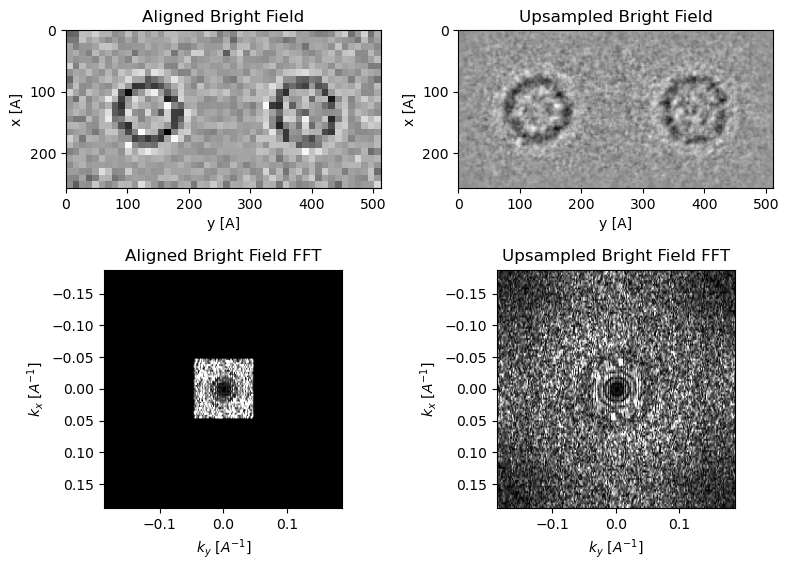

In [12]:
#| label: app:py4dstem_parallax_subpixel

parallax = parallax.subpixel_alignment(
    kde_upsample_factor=4,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
    figsize=(8,6),
    cmap='gray'
)

### Aberration Fitting

Rotation of Q w.r.t. R = -12.790 deg
Astigmatism (A1x,A1y)  = (560,-1010) Ang
Aberration C1          =  -14202 Ang
Defocus dF             = 14202 Ang
Transpose              = False


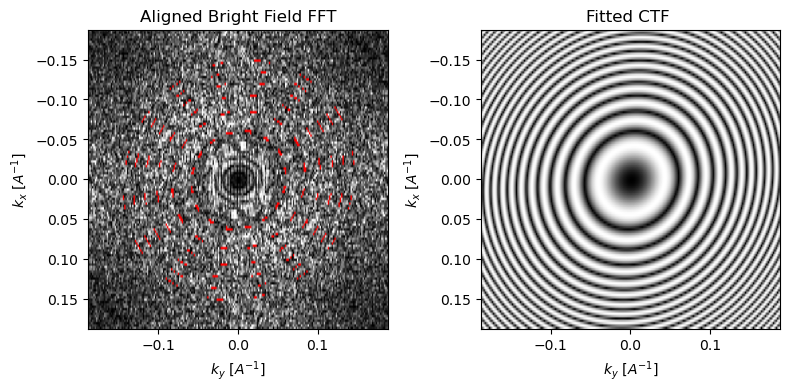

In [13]:
#| label: app:py4dstem_parallax_fitting

parallax = parallax.aberration_fit(
    plot_CTF_comparison=True,
)

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -12.790 deg
Astigmatism (A1x,A1y)  = (560,-1010) Ang
Aberration C1          =  -14202 Ang
Defocus dF             = 14202 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -14209
stig            2        2         y      -1011
stig            2        2         x      559
coma            3        1         y      -53920
coma            3        1         x      -102269
trefoil         3        3         x      -70
trefoil         3        3         y      137


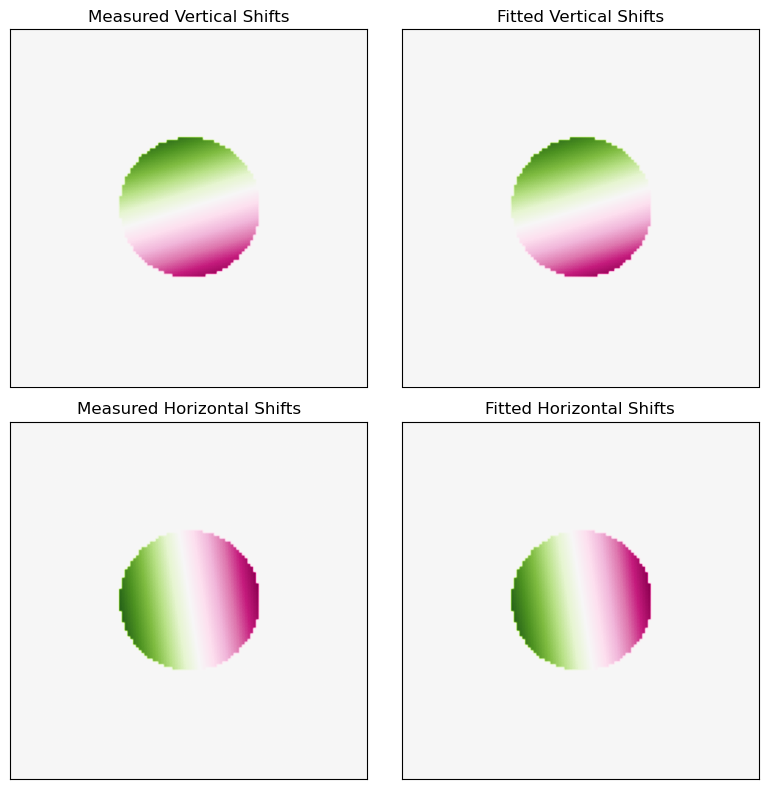

In [15]:
#| label: app:py4dstem_parallax_fitting_higher

parallax = parallax.aberration_fit(
    fit_BF_shifts=True,
    fit_aberrations_max_radial_order=3,
    fit_aberrations_max_angular_order=3,
    plot_BF_shifts_comparison=True,
)

### Aberration Correction

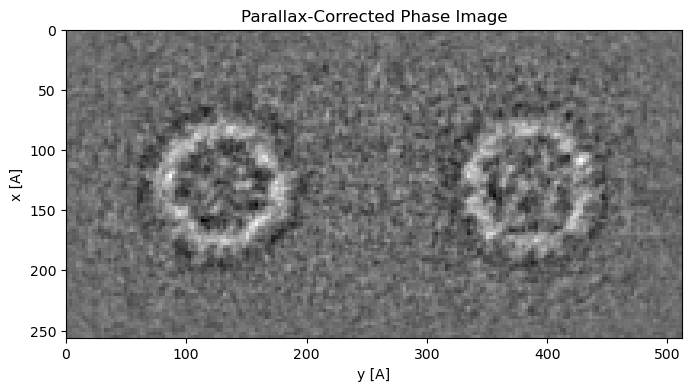

In [16]:
#| label: app:py4dstem_parallax_correction

parallax = parallax.aberration_correct(
    figsize=(8,4),
    cmap='gray'
)